<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/final_project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import lightgbm as lgb
import sklearn
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

pd.set_option('display.max_columns' , 500)
pd.set_option('display.width', 300)

print('Library imported.')


Library imported.


In [2]:
import multiprocessing

multiprocessing.cpu_count()

2

In [3]:
from google.colab import files

uploaded = files.upload() # upload kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!kaggle competitions download -c competitive-data-science-predict-future-sales
!unzip \*.zip

Saving kaggle.json to kaggle.json
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 6.64MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 65.4MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 68.6MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 117MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.42MB/s]
 38% 5.00M/13.3M [00:00<00:00, 51.1MB/s]
100% 13.3M/13.3M [00:00<00:00, 64.9MB/s]
Archive:  items.csv.zip
  inflating: items.csv               

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  sales_train.csv.zip
  inflating: sales_train.csv         

4 archives were successfully processed.


In [4]:

item_cat = pd.read_csv('item_categories.csv')
item = pd.read_csv('items.csv')
sale_train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')

test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

print('Files imported.')


Files imported.


In [5]:
print(test.head())
print(sample_submission.head())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5


In [6]:
print('Items: ')
print(item.head(), '\n')

print('Item category:')
print(item_cat.head(), '\n')

print('Shops data:')
print(shops.head(), '\n')

print('Sales train_data')
print(sale_train.head(), '\n')




Items: 
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40 

Item category:
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4 

Shops data:
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"      

###I assume that since I have shop_id and item_category_id, shop name and item_category name is unnecessary. However, we preserve this feature first, assume meaningless features may contain data leakage.
###Thus, when I combine the dataset.

In [7]:
item = item.merge(item_cat, how = 'left', on = 'item_category_id')
sale_train = sale_train.merge(shops, how = 'left', on = 'shop_id')
train = sale_train.merge(item, how = 'left', on = 'item_id')
test = test.merge(item, how = 'left', on = 'item_id')
test = test.merge(shops, how = 'left', on = 'shop_id')
print('Train data:')
print(train.shape)
print(train.head())

print('Test data:')
print(test.shape)
print(test.head())

Train data:
(2935849, 10)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name
0  02.01.2013               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray
1  03.01.2013               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил
2  05.01.2013               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил
3  06.01.2013               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP                58                       Музыка - Винил

In [8]:
print(train['item_id'].nunique())
print(train['item_name'].nunique())

21807
21807


##Task framework: Use 2013/1 ~ 2015/10 data, to predict 2015/11 data
###We have training data with 10 features, test data with 6 features(not counting the ID). Train data contains features that test data don't have: [date, date_block_num, item_cnt_day]. 
###We should take into account the time context of the data
###1. Given current shop and item, predict total sales of whole month
###2. Apply time sequence feature, (shop + item) * several months + past monthly  sales * several months = future monthly sales

In [9]:
# First preprocess date data: For train set, extract year and month from date column
# Original date format: dd/mm/yyyy
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
print(train.info())
print(train.head())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
 10  month               int64         
 11  year                int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 291.2+ MB
None
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year
0 2013-01-02               0    

In [10]:
# Since test data is from 2015 November, we could create date features for test data
test['month'] = 11
test['year'] = 2015
test['date_block_num'] = 34
print(test.head())

   ID  shop_id  item_id                                          item_name  item_category_id                   item_category_name               shop_name  month  year  date_block_num
0   0        5     5037                     NHL 15 [PS3, русские субтитры]                19                           Игры - PS3  Вологда ТРЦ "Мармелад"     11  2015              34
1   1        5     5320                    ONE DIRECTION  Made In The A.M.                55  Музыка - CD локального производства  Вологда ТРЦ "Мармелад"     11  2015              34
2   2        5     5233  Need for Speed Rivals (Essentials) [PS3, русск...                19                           Игры - PS3  Вологда ТРЦ "Мармелад"     11  2015              34
3   3        5     5232  Need for Speed Rivals (Classics) [Xbox 360, ру...                23                      Игры - XBOX 360  Вологда ТРЦ "Мармелад"     11  2015              34
4   4        5     5268               Need for Speed [PS4, русская версия]           

In [11]:
print(train.columns)
print(test.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_id', 'item_category_name', 'month', 'year'], dtype='object')
Index(['ID', 'shop_id', 'item_id', 'item_name', 'item_category_id', 'item_category_name', 'shop_name', 'month', 'year', 'date_block_num'], dtype='object')


###Now the only difference in train and test features is item_cnt_day.

In [12]:
#Start EDA for train and test data
print(train.head())
print(test.head())
# make the column of test aligned with train set
col_train = [col for col in train.columns if col in test.columns]
test = pd.concat([test['ID'], test[col_train]], axis = 1)


        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year
0 2013-01-02               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray      1  2013
1 2013-01-03               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
2 2013-01-05               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
3 2013-01-06               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP                58                

In [13]:
print(train.head())
print(test.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year
0 2013-01-02               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray      1  2013
1 2013-01-03               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
2 2013-01-05               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
3 2013-01-06               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP                58                

In [14]:
# Sum up different days value into monthly
train['cnt_monthly'] = train.groupby(['year', 'month', 'shop_id', 'item_id'])['item_cnt_day'].transform(sum)
print(train.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year  cnt_monthly
0 2013-01-02               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray      1  2013          1.0
1 2013-01-03               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013          0.0
2 2013-01-05               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013          0.0
3 2013-01-06               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do Yo

###Train shape: (2935849,13)

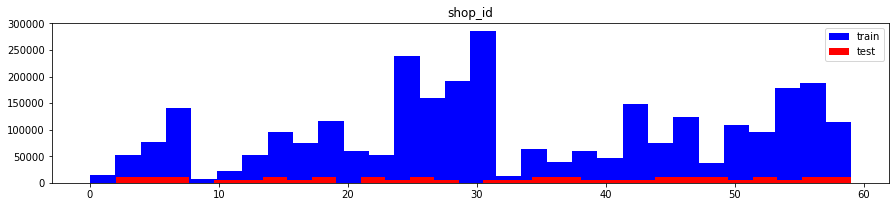

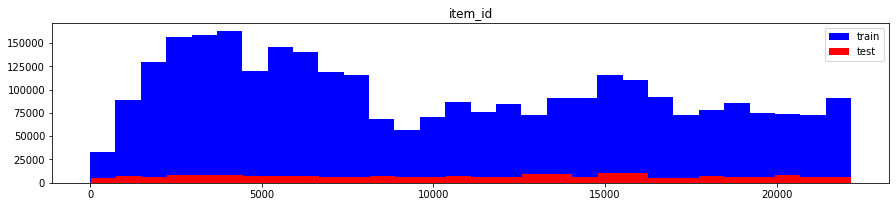

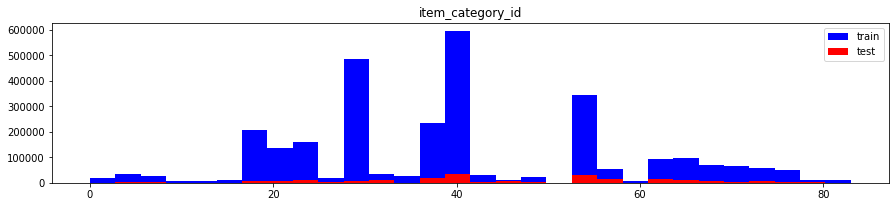

In [15]:
#Observe distributions of features in train and test set

cat_feature = ['shop_id', 'item_id', 'item_category_id']
for col in range(len(cat_feature)):
   plt.figure(figsize = (15, 10))
   plt.subplot(len(cat_feature), 1, col+1)
   plt.hist(train[cat_feature[col]], bins = 30, color = 'blue', label = 'train')
   plt.hist(test[cat_feature[col]], bins = 30, color = 'red', label = 'test')
   plt.title(str(cat_feature[col]))
   plt.legend()



In [16]:
train['item_category_id'].nunique()

84

###The train category features contains all distributions of test category features, though the distribution is not all shaped the same.

In [17]:
#Examine dirty data: Nan values, Outlier, duplicate features, duplicate rows
print('Null values in train:\n', train.isnull().sum())
print('Null values in test:\n', test.isnull().sum())

#outliers



Null values in train:
 date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
month                 0
year                  0
cnt_monthly           0
dtype: int64
Null values in test:
 ID                    0
date_block_num        0
shop_id               0
item_id               0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
month                 0
year                  0
dtype: int64


In [18]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,cnt_monthly
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1,2013,1.0
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,0.0
2,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,0.0
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,1,2013,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,1,2013,1.0


###Assume some properties that my affect item monthly sells:
###Does different shop tend to sold more of less item?
###Does certain item category tend to sold more of less item?
###And the analyzation result comparing train and test set

###Feature infrastructure to analyze: Feature statistics within itself, Feature statistics between features, Feature statistics against target.

###We suppose EDA could help us not only analyze the data structure, but also help feature engineering: feature selection(What feature is significant to target, what feature is meaningless), feature generation, data cleaning & transformation.

In [19]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,year,cnt_monthly
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01,6.247717e+00,2.013777e+03,7.400887e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01,3.536219e+00,7.684790e-01,3.033513e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,1.000000e+00,2.013000e+03,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01,3.000000e+00,2.013000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01,6.000000e+00,2.014000e+03,2.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01,9.000000e+00,2.014000e+03,5.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01,1.200000e+01,2.015000e+03,2.253000e+03


###Assume elements that correlated to sales: year+month, shop+item, shop+item_category, year+month+shop+item, year+month+shop+item_category


###Observe the distribution of feature values corresponding to the target distribution

In [20]:
train['y_m'] = train['year'].astype(str) + train['month'].astype(str)
train['shop_item'] = train['shop_name'] + train['item_name']
train['shop_item_cat'] = train['shop_name'] + train['item_category_name']
train['y_m_shop_item'] = train['year'].astype(str) + train['month'].astype(str) + train['shop_name'] + train['item_name']
train['y_m_shop_cat'] = train['year'].astype(str) + train['month'].astype(str) + train['shop_name'] + train['item_category_name']

In [21]:
train_ = train.sort_values(by = 'cnt_monthly', ascending = True, axis = 0)

In [22]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,cnt_monthly,y_m,shop_item,shop_item_cat,y_m_shop_item,y_m_shop_cat
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1,2013,1.0,20131,"Ярославль ТЦ ""Альтаир""ЯВЛЕНИЕ 2012 (BD)","Ярославль ТЦ ""Альтаир""Кино - Blu-Ray","20131Ярославль ТЦ ""Альтаир""ЯВЛЕНИЕ 2012 (BD)","20131Ярославль ТЦ ""Альтаир""Кино - Blu-Ray"
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,0.0,20131,"Москва ТРК ""Атриум""DEEP PURPLE The House Of B...","Москва ТРК ""Атриум""Музыка - Винил","20131Москва ТРК ""Атриум""DEEP PURPLE The House...","20131Москва ТРК ""Атриум""Музыка - Винил"
2,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,0.0,20131,"Москва ТРК ""Атриум""DEEP PURPLE The House Of B...","Москва ТРК ""Атриум""Музыка - Винил","20131Москва ТРК ""Атриум""DEEP PURPLE The House...","20131Москва ТРК ""Атриум""Музыка - Винил"
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,1,2013,1.0,20131,"Москва ТРК ""Атриум""DEEP PURPLE Who Do You Thi...","Москва ТРК ""Атриум""Музыка - Винил","20131Москва ТРК ""Атриум""DEEP PURPLE Who Do Yo...","20131Москва ТРК ""Атриум""Музыка - Винил"
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,1,2013,1.0,20131,"Москва ТРК ""Атриум""DEEP PURPLE 30 Very Best Of...","Москва ТРК ""Атриум""Музыка - CD фирменного прои...","20131Москва ТРК ""Атриум""DEEP PURPLE 30 Very Be...","20131Москва ТРК ""Атриум""Музыка - CD фирменного..."


In [23]:
#Convert category features by encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
cat_feature = train_.select_dtypes(include = 'object')

gc.collect()

19800

Text(0, 0.5, 'item price')

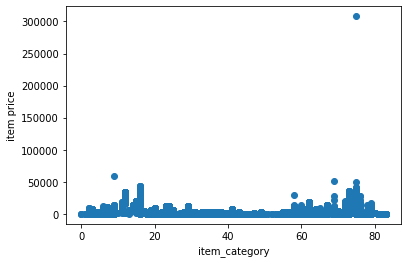

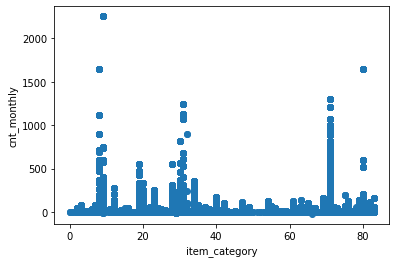

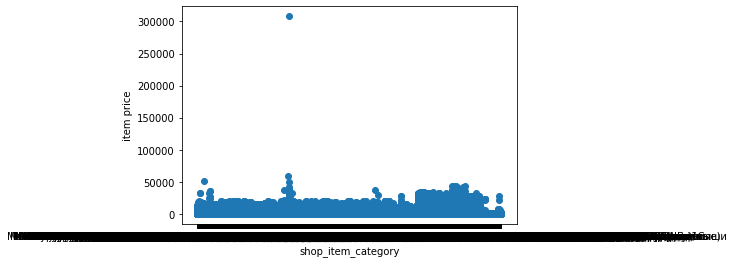

In [24]:
# Correlation between features

plt.figure(1)
plt.scatter(train['item_category_id'], train['item_price'])
plt.xlabel('item_category')
plt.ylabel('item price')

plt.figure(2)
plt.scatter(train['item_category_id'], train['cnt_monthly'])
plt.xlabel('item_category')
plt.ylabel('cnt_monthly')

plt.figure(3)
plt.scatter(train['shop_item_cat'], train['item_price'])
plt.xlabel('shop_item_category')
plt.ylabel('item price')


In [25]:
# Encode categorical features
# normalization
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

encoder = LabelEncoder()
scaler = StandardScaler()

for feature in train.columns:
  if train[feature].dtype == 'object':
    train[feature] = encoder.fit_transform(train[feature])
    train[feature] = scaler.fit_transform(train[feature].values.reshape(-1, 1))

  else:
    train[feature] = scaler.fit_transform(train[feature].values.reshape(-1, 1))

print('Process finished.')
print(train.head())


Process finished.
       date  date_block_num   shop_id   item_id  item_price  item_cnt_day  shop_name  item_name  item_category_id  item_category_name     month      year  cnt_monthly       y_m  shop_item  shop_item_cat  y_m_shop_item  y_m_shop_cat
0 -1.590241        -1.54621  1.602164  1.890609    0.062520     -0.092652   1.602164   1.892206         -0.175512           -0.175512 -1.483991 -1.010893    -0.211006 -1.526979   1.706152       1.603223      -1.210091     -1.151900
1 -1.586756        -1.54621 -0.493113 -1.208866    0.004710     -0.092652  -0.493113  -1.208576          1.052504            1.052504 -1.483991 -1.010893    -0.243971 -1.526979  -0.603110      -0.504246      -1.296086     -1.207161
2 -1.579784        -1.54621 -0.493113 -1.208866    0.004710     -0.856351  -0.493113  -1.208576          1.052504            1.052504 -1.483991 -1.010893    -0.243971 -1.526979  -0.603110      -0.504246      -1.296086     -1.207161
3 -1.576299        -1.54621 -0.493113 -1.208550    0.4

(array([ 78118.,  26641., 505305., 537510., 858522.,  64240., 398892.,
        195895., 195545.,  75181.]),
 array([-2.33915879, -1.85380012, -1.36844145, -0.88308278, -0.39772412,
         0.08763455,  0.57299322,  1.05835189,  1.54371056,  2.02906923,
         2.5144279 ]),
 <a list of 10 Patch objects>)

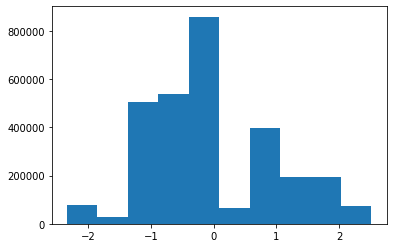

In [26]:
plt.hist(train['item_category_id'])

In [39]:
#Observe feature importance 
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

ridge = Ridge()
lasso = Lasso()
svc = LinearSVR(C = 0.01, dual=False, loss='squared_epsilon_insensitive')
tree = DecisionTreeRegressor(max_depth = 50, min_samples_leaf=5)

models = {'Ridge':ridge, 'Lasso':lasso, 'SVM':svc, 'DTree':tree}


y = train['cnt_monthly']
X = train.drop('cnt_monthly', axis = 1)
for i in range(len(models)):
  model = models[list(models.keys())[i]]
  
  selector = SelectFromModel(model, threshold=0.001)
  selector.fit(X, y)
  feature_idx = selector.get_support()
  print('Selected features from {} is:'.format(list(models.keys())[i]))
  print(X.columns[feature_idx])



Selected features from Ridge is:
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_id', 'item_category_name', 'month', 'year', 'y_m', 'shop_item', 'shop_item_cat', 'y_m_shop_item', 'y_m_shop_cat'], dtype='object')
Selected features from Lasso is:
Index([], dtype='object')
Selected features from SVM is:
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_id', 'item_category_name', 'month', 'year', 'y_m', 'shop_item', 'shop_item_cat', 'y_m_shop_item', 'y_m_shop_cat'], dtype='object')
Selected features from DTree is:
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_id', 'item_category_name', 'month', 'y_m', 'shop_item', 'shop_item_cat', 'y_m_shop_item', 'y_m_shop_cat'], dtype='object')


In [31]:
print(list(models.keys())[1])

Lasso


In [ ]:
import holidays
from datetime import date

# Add holiday feature for each date 
ru_holiday = holidays.Russia()

dates = train['date']
for i in range(len(dates)):
  if dates[i] in ru_holiday:
    dates[i] = 1
  elif dates[i] not in ru_holiday:
    dates[i] = 0

train['is_holiday'] = dates

